# E-29 Graduate Project
### By: Shi Luo

The data come from https://www.kaggle.com/aaron7sun/stocknews

Two channels of data are provided in the dataset:
1. News data: this dataset includes historical news headlines from Reddit WorldNews Channel. For each day there are top 25 headlines selected by reddit users' votes, and the range is from 2008-06-08 to 2016-07-01.
2. Stock data: Dow Jones Industrial Average (DJIA) is used as the representitive of stock market and the range is from 2008-08-08 to 2016-07-01.

In this project, the Top 25 daily news headlines are used to predict the Rate of Returns for Djia.
The methods include GloVe embedding, Recurrent Neural Network based models and Convolutional Neural Network model.

## Import Libraries

In [715]:
#basic
import pandas as pd
import numpy as np
import re
import string
from functools import reduce

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#scikit
from sklearn.metrics import median_absolute_error

#keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Convolution1D, MaxPooling1D, Dropout, Activation, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop

#matplotlib
import matplotlib.pyplot as plt


## Import data

Combined_News_DJIA.csv: The first column is "Date". There are 25 lines for each date and all news are ranked from top to bottom based on how hot they are.

In [713]:
News=pd.read_csv("Combined_News_DJIA.csv")
print(News.shape)
print(News.iloc[0:1,2:6].values)
News.head(2)


(1989, 27)
[[ 'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"'
  "b'BREAKING: Musharraf to be impeached.'"
  "b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)'"
  "b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'"]]


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [716]:
Djia=pd.read_csv("DJIA_table.csv")
print(Djia.shape)
Djia.head()

(1989, 7)


,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [717]:
#drop rows with empty and Nan values
News.replace('', np.nan, inplace=True)
News= News.dropna(how='any')

In [718]:
#drop rows with empty and Nan values
Djia.replace('', np.nan, inplace=True)
Djia= Djia.dropna(how='any')

In [719]:
print(News.shape)
print(Djia.shape)

(1986, 27)
(1989, 7)


## Data Processing

### Calculate the Rate of Return based on Close Prices

To measure the movement of the Djia prices, I calculated the Rate Of Return by using the following formulation:

$Rate  Of  Return=( Close_t/Close_{t-1} – 1)*100$

In [720]:
#reverse the Date
Djia=Djia[::-1]

#reset index
Djia.reset_index(drop=True,inplace=True)

#calculate Rate of Return
Djia['Rate of Return']=(Djia['Close'].pct_change())*100

#drop all other columns
Djia = Djia.drop(['Open','High','Low','Close','Volume','Adj Close'], 1)

#drop row0
Djia=Djia.drop(0,axis=0)

#reset index
Djia.reset_index(drop=True,inplace=True)

print(Djia.shape)
Djia.head(3)

(1988, 2)


,Date,Rate of Return
0,2008-08-11,0.409306
1,2008-08-12,-1.187199
2,2008-08-13,-0.940606


In [721]:
#merge News and Djia
data1=Djia.merge(News,on=["Date"],how="inner")
print(data1.shape)
data1.head(3)

(1985, 28)


,Date,Rate of Return,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-11,0.409306,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
1,2008-08-12,-1.187199,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2,2008-08-13,-0.940606,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...


### Create input and output datasets

In [722]:
#combine 25 news into 1
cols=data1.columns[3:28]
data1['combined']=reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=' '), 
                 [data1[i] for i in cols])
data1['combined'][0]

'b\'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?\' b\'Bush puts foot down on Georgian conflict\' b"Jewish Georgian minister: Thanks to Israeli training, we\'re fending off Russia " b\'Georgian army flees in disarray as Russians advance - Gori abandoned to Russia without a shot fired\' b"Olympic opening ceremony fireworks \'faked\'" b\'What were the Mossad with fraudulent New Zealand Passports doing in Iraq?\' b\'Russia angered by Israeli military sale to Georgia\' b\'An American citizen living in S.Ossetia blames U.S. and Georgian leaders for the genocide of innocent people\' b\'Welcome To World War IV! Now In High Definition!\' b"Georgia\'s move, a mistake of monumental proportions " b\'Russia presses deeper into Georgia; U.S. says regime change is goal\' b\'Abhinav Bindra wins first ever Individual Olympic Gold Medal for India\' b\' U.S. ship heads for Arctic to define territory\' b\'Drivers in a Jerusalem taxi station threaten to quit ra

In [723]:
#create a list of headlines which will be convered into our input dataset
Headlines=list(data1['combined'].copy())

print(len(Headlines))

1985


In [724]:
#create a list of corresponding Rate_of_Returns as our output dataset
Rate_of_Return=list(data1['Rate of Return'].copy())
print(len(Rate_of_Return))


1985


### Clean data

This fuction includes removing punctuations, onverting words to lower case, remove stop words, replacing certain expressions and emmatising words to their original forms.
    

In [725]:
#define a function to clean data
def clean(news):
    
    #Remove punctuations
    news = news.translate(string.punctuation)
    
    #Convert words to lower case and split them
    news = news.lower().split()   
    
    #Remove stop words
    sp=set(stopwords.words("english"))
    news = [i for i in news if not i in sp and len(i) >= 3]   
    
    news = " ".join(news)

    # replace certain expressions
    news= re.sub(r"wont", "will not",news)
    news= re.sub(r"i'm", "i am ",news)
    news= re.sub(r"\'re", " are ",news)
    news= re.sub(r"\'d", " would ",news)
    news= re.sub(r"\'ll", " will ",news)
    news= re.sub(r"\'ve", " have ",news)
    news= re.sub(r"n't", " not ",news)
    news= re.sub(r"what's", "what is ",news)
    news= re.sub(r"\'s", " ",news)
    news = re.sub(r' s ', ' ', news)
    
    news= re.sub(r"b", " ",news)    
    news= re.sub(r",", " ",news)
    news= re.sub(r"\.", " ",news)
    news= re.sub(r"!", " ! ",news)
    news= re.sub(r"\/", " ",news)
    news= re.sub(r"\^", " ^ ",news)
    news= re.sub(r"\+", " + ",news)
    news= re.sub(r"\-", " - ",news)
    news= re.sub(r"\=", " = ",news)
    news= re.sub(r"'", " ",news)
    news = re.sub(r'\'', ' ', news)
    news = re.sub(r'\$', ' $ ', news)
    news= re.sub(r":", " : ",news)

    news= re.sub(r"\0s", "0",news)
    news= re.sub(r"e - mail", "email",news)
    news = re.sub(r' yr ', ' year ', news)
    news= re.sub(r"\s{2,}", " ",news)
    news= re.sub(r" e g ", " eg ",news)    
    news = re.sub(r'&amp;', '', news) 
    news = re.sub(r'0,0', '00', news) 
    news = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", news)
    news= re.sub(r"(\d+)(k)", r"\g<1>000",news)
    news = re.sub(r'u s ', ' united states ', news)
    news = re.sub(r'u n ', ' united nations ', news)
    news = re.sub(r'u k ', ' united kingdom ', news)

    
    news=news.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    lem_word = [lem.lemmatize(word, "v") for word in news]

    news = " ".join(lem_word)

    return news

In [726]:
Headlines_Clean=[]

for i in range(len(Headlines)):
    Headlines_Clean.append(clean(Headlines[i]))


In [727]:
Headlines_Clean[1900]

'kim jong - un order nuclear weapons make ready use mexican officials pass proposal an donald trump country tens thousands nigerian fishermen farmers give green light sue energy giant shell ritish court wednesday series destructive oil spill niger delta past decade chief receive 20 pay package hike despite record loss 7 000 ax jo s time crisis oil company o dudley earn 14m last year amount high pay centre descri es contact reality uk face ook force pay millions tax widespread controversy pay 4 327 tax last year refugee crisis put truckers live risk say road transport lo y world food price fall 14 5 even canadian food price clim usiness monsanto threaten pull india government impose ig cut royalties local firm pay genetically modify cotton seed average temperatures across northern hemisphere reach degrees celsius normal mark first time record history scientists find cancer achilles heel pakistani police rescue nine - year - old girl marry 14 - year - old oy settle family dispute friday 

### Tokenization

In [673]:
# create the tokenizer
vsize=20000
maxlen=300
t = Tokenizer(num_words= vsize)

# fit the tokenizer on the text
t.fit_on_texts(Headlines_Clean)
#print(t.word_counts)
#print(t.document_count)
#print(t.word_index)
#print(t.word_docs)

#Converts the text to a sequence of words or tokens.
s = t.texts_to_sequences(Headlines_Clean)

#Pads sequences to the same length
Headlines_Pad = pad_sequences(s, maxlen=maxlen)

In [703]:
print(Headlines_Pad.shape)
Headlines_Pad[1900]

(1985, 300)


array([  171,  1359,  2475,   974,    86,   899,   896,   617,   327,
         797,   726,    78,    49,   623,  1505,  6239,    71,   844,
        3912,  3805,   531,  1201,   268,   586,   790,   106,  2183,
        3043,   406,   202,  1627,   495,    19,  5042,   485,   161,
          43,   201,    71,   140,    50, 14935,  1894, 10571,    70,
          17,  1269,   220,   106,  1121,   943,  1066,  1911,  2298,
         259,    48,   322,    28,   106,   552,   204,  2124,  2594,
         106,   534, 16110,   204,    70,    17,  1226,   201,   329,
         101,   540,     1,   721,  2212,  1301,   441,     7,   247,
         364,   473,  1465,   351,   227,   210,   247,   364,  2810,
         756,  1870,   181,  1117,    65,    10,  1028,   467,   209,
        7183,   624,   496,   106,  2933,  2850,  5268,  2416,  1825,
        2847,   348,   512,  6965,   338,  3782,  6082,  3309,  1116,
          30,    43,   202,   465,   278,    20,   752, 15299,  9373,
         544,    12,

### Apply GloVe's embeddings

GloVe (Global Vectors for Word Representation), released by Stanford NLP Group researchers, is for learning continuous-space vector representations of words. This tool is suggested to be competitive with Google’s word2vec package.

I chose 'glove.840B.300d.txt' as embeddings. Before training the model, I need to construct a co-occurrence matrix "embedding_matrix", in which each cell represents how often the word i appears in the context of the word j. I applied the values of this matrix to the models.


In [729]:
# Load GloVe's embeddings
embeddings_index = {}
g = open('/Users/meroco/Document/Harvard/Python/GloVe/glove.840B.300d.txt',encoding='utf-8')

for line in g:
    values = line.split(' ')
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = embedding
g.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2196017 word vectors.


In [772]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vsize, 300))
for word, index in t.word_index.items():
    if index > vsize - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
print(embedding_matrix.shape)

(20000, 300)


In [771]:
embedding_matrix

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -3.20769995e-01,   5.16240001e-01,  -3.52789998e-01, ...,
          1.84019998e-01,   4.51810002e-01,   5.26209995e-02],
       [  1.79250002e-01,   1.33430004e-01,   5.03489971e-01, ...,
         -5.65450013e-01,   9.51320007e-02,   6.42319992e-02],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -1.09270001e-02,  -9.14940014e-02,   8.05949986e-01, ...,
          4.34789985e-01,  -5.45450021e-04,  -7.27600008e-02],
       [  2.48669997e-01,   8.32810029e-02,   2.78600007e-02, ...,
         -4.36210006e-01,   8.27880025e-01,   5.72790027e-01]])

## Build model

### Set parameters

In [731]:
#set parameters
training_samples = 1600 
validation_samples = len(Rate_of_Return)-training_samples
max_words = 20000 
embedding_dim = 300 
dropout=0.2
filter_num=16
filter_len=3

### Model1

In model1, I applied GloVe embedding and SimpleRNN as layers.

Word embedding is the way how we represent words to input them to a neural network.

In [732]:
#model with GloVe and SimpleRNN
model1 = Sequential() 
model1.add(Embedding(vsize, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False)) 
model1.add(SimpleRNN(32, return_sequences=True))
model1.add(SimpleRNN(32, return_sequences=True))
model1.add(SimpleRNN(32))
model1.add(Dropout(dropout))
model1.add(Dense(1, activation='sigmoid')) 
model1.compile(optimizer=RMSprop(), loss='mae') 
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
simple_rnn_43 (SimpleRNN)    (None, 300, 32)           10656     
_________________________________________________________________
simple_rnn_44 (SimpleRNN)    (None, 300, 32)           2080      
_________________________________________________________________
simple_rnn_45 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dropout_39 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 6,014,849
Trainable params: 14,849
Non-trainable params: 6,000,000
_____________________________________________________________

### Model2

I implemented GloVe embedding, Convolution1D and long short term memory (LSTM) networks layers in model2.

The Convolution1D layer creates a convolution kernel that is convolved with the layer input over a single spatial dimension to produce a tensor of outputs.

A LSTM network is also a kind of recurrent neural network, which attempts to model time or sequence dependent behaviour – such as language, stock prices. 


In [745]:
#model with GloVe, Convolution1D and LSTM
model2 = Sequential()    
model2.add(Embedding(vsize, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model2.add(Convolution1D(filters = filter_num, kernel_size = filter_len, padding = 'same',activation = 'relu'))
model2.add(Dropout(dropout))
model2.add(Convolution1D(filters = filter_num, kernel_size = filter_len, padding = 'same',activation = 'relu'))
model2.add(Dropout(dropout))
model2.add(LSTM(100))
model2.add(Dense(1, name='output'))
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 300, 16)           14416     
_________________________________________________________________
dropout_42 (Dropout)         (None, 300, 16)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 300, 16)           784       
_________________________________________________________________
dropout_43 (Dropout)         (None, 300, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               46800     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total para

## Split data

In [746]:
# Split data into training and testing sets.
x_train = Headlines_Pad[:training_samples] 
y_train = Rate_of_Return[:training_samples] 
x_val = Headlines_Pad[training_samples: training_samples + validation_samples] 
y_val = Rate_of_Return[training_samples: training_samples + validation_samples]

# Check the lengths
print(len(x_train))
print(len(x_val))

1600
385


## Fit model

In [757]:
#fit model1
model1.fit(x_train, y_train, epochs = 30,validation_data=(x_val, y_val)) 

Train on 1600 samples, validate on 385 samples
Epoch 1/30
1600/1600 [==============================] - 11s 7ms/step - loss: 0.6071 - val_loss: 0.8112
Epoch 2/30
1600/1600 [==============================] - 11s 7ms/step - loss: 0.6059 - val_loss: 0.8108
Epoch 3/30
1600/1600 [==============================] - 11s 7ms/step - loss: 0.6062 - val_loss: 0.8105
Epoch 4/30
1600/1600 [==============================] - 10s 6ms/step - loss: 0.6090 - val_loss: 0.8032
Epoch 5/30
1600/1600 [==============================] - 10s 6ms/step - loss: 0.6036 - val_loss: 0.7845
Epoch 6/30
1600/1600 [==============================] - 10s 6ms/step - loss: 0.6055 - val_loss: 0.8101
Epoch 7/30
1600/1600 [==============================] - 11s 7ms/step - loss: 0.6033 - val_loss: 0.8063
Epoch 8/30
1600/1600 [==============================] - 11s 7ms/step - loss: 0.6029 - val_loss: 0.7903
Epoch 9/30
1600/1600 [==============================] - 11s 7ms/step - loss: 0.6006 - val_loss: 0.7967
Epoch 10/30
1600/1600 [===

In [759]:
model2.fit(x_train, y_train, epochs = 30, validation_data=(x_val, y_val)) 

Train on 1600 samples, validate on 385 samples
Epoch 1/30
1600/1600 [==============================] - 16s 10ms/step - loss: 0.1714 - val_loss: 1.2652
Epoch 2/30
1600/1600 [==============================] - 13s 8ms/step - loss: 0.1518 - val_loss: 1.2368
Epoch 3/30
1600/1600 [==============================] - 14s 9ms/step - loss: 0.1583 - val_loss: 1.3026
Epoch 4/30
1600/1600 [==============================] - 14s 9ms/step - loss: 0.1504 - val_loss: 1.2702
Epoch 5/30
1600/1600 [==============================] - 13s 8ms/step - loss: 0.1520 - val_loss: 1.2237
Epoch 6/30
1600/1600 [==============================] - 13s 8ms/step - loss: 0.1423 - val_loss: 1.2721
Epoch 7/30
1600/1600 [==============================] - 13s 8ms/step - loss: 0.1464 - val_loss: 1.1974
Epoch 8/30
1600/1600 [==============================] - 14s 9ms/step - loss: 0.1481 - val_loss: 1.2813
Epoch 9/30
1600/1600 [==============================] - 13s 8ms/step - loss: 0.1422 - val_loss: 1.2056
Epoch 10/30
1600/1600 [==

## Results

In [749]:
prediction1 = model1.predict([x_val], verbose = True)

385/385 [==============================] - 1s 3ms/step


In [760]:
prediction2 = model2.predict([x_val], verbose = True)

385/385 [==============================] - 1s 2ms/step


In [751]:
#calculate accuracy for model1
count1=0
for i in range(validation_samples):
    if prediction1[i]*y_val[i]>0:
        count1+=1
print("Predicted values in model1 matched the actual direction",round(count1/validation_samples,4)*100,"% of the time.")

Predicted values in model1 matched the actual direction 50.91 % of the time.


In [761]:
#calculate accuracy for model2
count2=0
for i in range(validation_samples):
    if prediction2[i]*y_val[i]>0:
        count2+=1
print("Predicted values in model2 matched the actual direction",round(count2/validation_samples,4)*100,"% of the time.")

Predicted values in model2 matched the actual direction 52.21 % of the time.


In [762]:
# Calculate the median absolute error for the predictions
print("The median_absolute_error for model1 is: ",median_absolute_error(y_val, prediction1))
print("The median_absolute_error for model2 is: ",median_absolute_error(y_val, prediction2))

The median_absolute_error for model1 is:  0.660997849282
The median_absolute_error for model2 is:  0.639826256972


## Vidualization

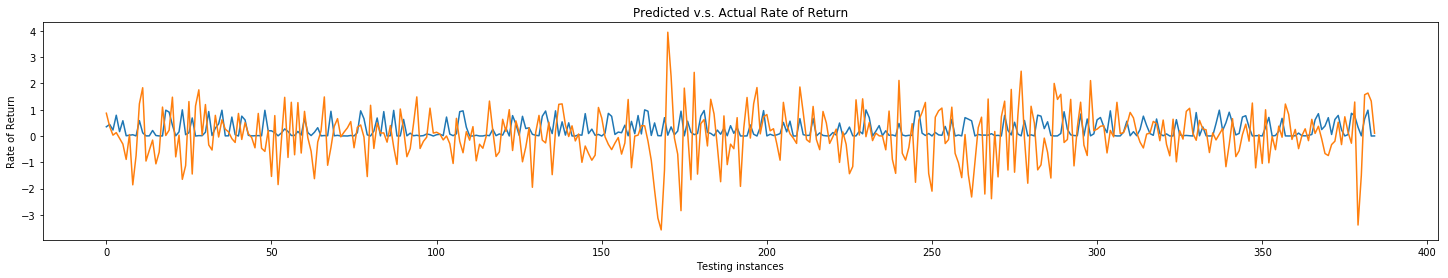

In [741]:
# Plot the predicted and actual values
plt.figure(figsize=(25,4))
plt.plot(prediction1)
plt.plot(y_val)
plt.title("Predicted v.s. Actual Rate of Return")
plt.xlabel("Testing instances")
plt.ylabel("Rate of Return")
plt.show()

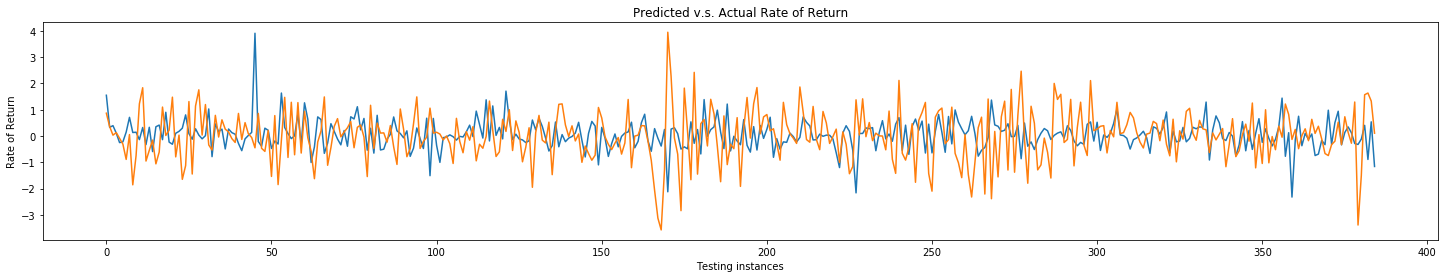

In [742]:
plt.figure(figsize=(25,4))
plt.plot(prediction2)
plt.plot(y_val)
plt.title("Predicted v.s. Actual Rate of Return")
plt.xlabel("Testing instances")
plt.ylabel("Rate of Return")
plt.show()

## Discussion

As the results show, these models only get accuracies over 50% in predicting the close price changes of the DJIA.
I think without considering that the market is a random walk I can make some improvements:
1. Narrow the range of the news and make them more relevent to the index or the stock market, such as economic news and industrial news.
2. Consider the time factors.

At last, I think predicting the capital markets would be a permanent task.
